# Imports

In [1]:
import random
import traceback
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw
import pandas as pd
from tqdm import tqdm
epsilon = 1e-3
import torch
from torch.utils.data import Dataset, DataLoader
# from TransPath_model import TransPathModel, GridData, TransPathLit
from search_algorithms import Map, Node, SearchTreePQD, make_path, octile_distance, astar, astar_func, wastar
import os

%matplotlib inline

In [2]:

class GridData(Dataset):
    """
    'mode' argument defines type of ground truth values:
        f - focal values
        h - absolute ideal heuristic values
        cf - correction factor values
    """
    def __init__(self, path, mode='f', clip_value=0.95, img_size=64):
        self.img_size = img_size
        self.clip_v = clip_value
        self.mode = mode

        self.maps   = np.load(os.path.join(path,    'maps.npy'),    mmap_mode='c')
        self.goals  = np.load(os.path.join(path,    'goals.npy'),   mmap_mode='c')
        self.starts = np.load(os.path.join(path,    'starts.npy'),  mmap_mode='c')

        file_gt = {'f' : 'focal.npy', 'h':'abs.npy', 'cf': 'cf.npy'}[mode]
        self.gt_values = np.load(os.path.join(path, file_gt), mmap_mode='c')


    def __len__(self):
        return len(self.gt_values)
    
    def __getitem__(self, idx):
        gt_ = torch.from_numpy(self.gt_values[idx].astype('float32'))
        if self.mode == 'f':
            gt_=  torch.where( gt_ >= self.clip_v, gt_ , torch.zeros_like( torch.from_numpy(self.gt_values[idx])))
        return (torch.from_numpy(self.maps[idx].astype('float32')), 
                torch.from_numpy(self.starts[idx].astype('float32')), 
                torch.from_numpy(self.goals[idx].astype('float32')), 
                gt_ )

In [3]:
import torch
from torch import nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    


class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64))
        self.down2 = (Down(64, 128))
        factor = 2 if bilinear else 1
        self.down3 = (Down(128, 256 // factor))

        self.up1 = (Up(256, 128 // factor, bilinear))
        self.up2 = (Up(128, 64 // factor, bilinear))
        self.up3 = (Up(64, 32, bilinear))
        self.outc = (OutConv(32, 1))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits


In [4]:
def mse_loss(pred, target, cells):
    return nn.MSELoss()(pred[~torch.isinf(target)], target[~torch.isinf(target)])


def mae_loss(pred, target, cells):
    return nn.L1Loss()(pred[~torch.isinf(target)], target[~torch.isinf(target)])


def piecewise_mae_loss(pred, target, cells, min_val, max_val, alpha1=1, alpha2=1):
    loss = 0
    for p, t in zip(pred[~torch.isinf(target)].flatten(), target[~torch.isinf(target)].flatten()):
        if p < min_val:
            loss += alpha1 * abs(p - t)
        elif p > max_val:
            loss += alpha2 * abs(p - t)
        else:
            loss += abs(p - t)
    return loss / len(pred.flatten())


def lossgrad_loss(pred, target, fake=None):
    kernel = torch.tensor([[1, 0, -1],
                            [2, 0, -2],
                            [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    kernel = kernel.to(pred.device)
    
    pred_grad_x = F.conv2d(pred.unsqueeze(0), kernel, padding=1)
    target_grad_x = F.conv2d(target.unsqueeze(0), kernel, padding=1)

    sobel_kernel_vertical = kernel.transpose(2, 3)
    
    pred_grad_y = F.conv2d(pred.unsqueeze(0), sobel_kernel_vertical, padding=1)
    target_grad_y = F.conv2d(target.unsqueeze(0), sobel_kernel_vertical, padding=1)
    
    x_ind = ~torch.isinf(target_grad_x) & ~torch.isnan(target_grad_x)
    y_ind = ~torch.isinf(target_grad_y) & ~torch.isnan(target_grad_y)

    grad_error_x = torch.abs(pred_grad_x[x_ind] - target_grad_x[x_ind])
    grad_error_y = torch.abs(pred_grad_y[y_ind] - target_grad_y[y_ind])

    loss = (grad_error_x.sum() + grad_error_y.sum()) / (len(grad_error_x) + len(grad_error_y))
    return loss


In [5]:
torch.serialization.add_safe_globals([nn.Conv2d])
torch.serialization.add_safe_globals([nn.Sequential])
torch.serialization.add_safe_globals([set])
torch.serialization.add_safe_globals([nn.BatchNorm2d])
torch.serialization.add_safe_globals([nn.ReLU])
torch.serialization.add_safe_globals([nn.MaxPool2d])
torch.serialization.add_safe_globals([nn.ConvTranspose2d]) 
 
torch.serialization.add_safe_globals([DoubleConv])
torch.serialization.add_safe_globals([Down])
torch.serialization.add_safe_globals([Up])
torch.serialization.add_safe_globals([OutConv])
torch.serialization.add_safe_globals([UNet])

torch.serialization.add_safe_globals([mse_loss])

In [6]:
def compute_octile_distances(p):
    """
    p: ndarray shape (N, 2), где N=100, A[i] = (x_i, y_i).
    Возвращает ndarray shape (N, 64, 64), в котором D[i,j,k] —
    octile-расстояние между точками (j, k) и (x_i, y_i) на i-ой карте.
    """
    jv, kv = np.meshgrid(np.arange(64), np.arange(64), indexing='ij')
    jv_ = jv[None, :, :]  # (1, 64, 64)
    kv_ = kv[None, :, :]  # (1, 64, 64)

    x_ = p[:, 0][:, None, None]  # (N, 1, 1)
    y_ = p[:, 1][:, None, None]  # (N, 1, 1)

    dx = np.abs(jv_ - x_)
    dy = np.abs(kv_ - y_)
    return np.maximum(dx, dy) + (np.sqrt(2) - 1) * np.minimum(dx, dy)


# Calculation

In [7]:
batch_size = 256
mode = 'h'


## On TransPath dataset

### Baseline

In [8]:
dataset_path = './TransPath_data/test'

limit = batch_size

test_data = GridData(
        path=f'{dataset_path}',
        mode=mode
    )

dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True
    )

cells, goals, starts, targets = \
    np.concatenate(next(iter(dataloader)), axis=1).T.mT.T
cells = cells.reshape(-1, 1, 64, 64)
goals = goals.reshape(-1, 1, 64, 64)
starts = starts.reshape(-1, 1, 64, 64)

metrics = {'path_length' : [], 'expanded_nodes_num' : []}

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = astar(map, start_i, start_j, goal_i, goal_j, octile_distance, SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['path_length'].append(length)
    metrics['expanded_nodes_num'].append(len(data[-1]))

100%|██████████| 256/256 [00:05<00:00, 46.69it/s]


In [9]:
df = pd.DataFrame.from_dict(metrics)

In [10]:
df.to_csv('./baseline_vanilla_astar_hl.csv', index=False)

### Model

In [11]:
eval_model : UNet = torch.load('checkpoints/mode=0-epoch=2999-timestr=0.ckpt', weights_only=True)['hyper_parameters']['model']

In [12]:
dataset_path = './TransPath_data'
accelerator = "cuda"
devices = [6]

test_data = GridData(
        path=f'{dataset_path}/test',
        mode=mode
    )

dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True
    )

eval_model.to(torch.device(f'{accelerator}:{devices[-1]}'))
eval_model.eval()
predictions = []
for map_design, starts, goals, gt_hmap in tqdm(dataloader):
    inputs = torch.cat([map_design, goals], dim=1) if mode in ('f', 'nastar') else torch.cat([map_design, goals], dim=1)
    inputs = inputs.to(torch.device(f'{accelerator}:{devices[-1]}'))
    
    with torch.no_grad():
        prediction = (eval_model(inputs) + 1) / 2 * 64 * 64

    predictions.append(prediction)

predictions = torch.cat(predictions).cpu().detach().numpy()

100%|██████████| 250/250 [00:05<00:00, 47.21it/s]


In [14]:
np.save(f'{dataset_path}/test/predicted_abs.npy', predictions)

In [15]:
dataset_path = './TransPath_data/test'

limit = batch_size

test_data = GridData(
        path=f'{dataset_path}',
        mode=mode
    )

dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True
    )

cells, goals, starts, targets = \
    np.concatenate(next(iter(dataloader)), axis=1).T.mT.T
heuristics = np.load(f'{dataset_path}/predicted_abs.npy', mmap_mode='c')[:limit]
cells = cells.reshape(-1, 1, 64, 64)
goals = goals.reshape(-1, 1, 64, 64)
starts = starts.reshape(-1, 1, 64, 64)

metrics = {'path_length' : [], 'expanded_nodes_num' : []}

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = astar(map, start_i, start_j, goal_i, goal_j, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['path_length'].append(length)
    metrics['expanded_nodes_num'].append(len(data[-1]))

100%|██████████| 256/256 [00:23<00:00, 10.95it/s]


In [16]:
df = pd.DataFrame.from_dict(metrics)

In [17]:
df.to_csv('./vanilla_astar_hl.csv', index=False)


## On AlekSet dataset

### Baseline

In [18]:
dataset_path = './AlekSet/test'

limit = batch_size

test_data = GridData(
        path=f'{dataset_path}',
        mode=mode
    )

dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True
    )

cells, goals, starts, targets = \
    np.concatenate(next(iter(dataloader)), axis=1).T.mT.T
cells = cells.reshape(-1, 1, 64, 64)
goals = goals.reshape(-1, 1, 64, 64)
starts = starts.reshape(-1, 1, 64, 64)

metrics = {'path_length' : [], 'expanded_nodes_num' : []}

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = astar(map, start_i, start_j, goal_i, goal_j, octile_distance, SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['path_length'].append(length)
    metrics['expanded_nodes_num'].append(len(data[-1]))

100%|██████████| 256/256 [00:06<00:00, 38.71it/s]


In [19]:
df = pd.DataFrame.from_dict(metrics)

In [20]:
df.to_csv('./alek_vanilla_astar_hl.csv', index=False)


#### Before FineTuning

In [21]:
eval_model : UNet = torch.load('checkpoints/mode=0-epoch=2999-timestr=0.ckpt', weights_only=True)['hyper_parameters']['model']

In [22]:
dataset_path = './AlekSet'
accelerator = "cuda"
devices = [6]

test_data = GridData(
        path=f'{dataset_path}/test',
        mode=mode
    )

dataloader = DataLoader(
        test_data, 
        batch_size=batch_size,
        shuffle=False, 
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True
    )

eval_model.to(torch.device(f'{accelerator}:{devices[-1]}'))
eval_model.eval()
predictions = []
for map_design, starts, goals, gt_hmap in tqdm(dataloader):
    inputs = torch.cat([map_design, goals], dim=1) if mode in ('f', 'nastar') else torch.cat([map_design, goals], dim=1)
    inputs = inputs.to(torch.device(f'{accelerator}:{devices[-1]}'))
    
    with torch.no_grad():
        prediction = (eval_model(inputs) + 1) / 2 * 64 * 64

    predictions.append(prediction)

predictions = torch.cat(predictions).cpu().detach().numpy()

100%|██████████| 63/63 [00:01<00:00, 52.82it/s]


In [23]:
np.save(f'{dataset_path}/test/predicted_abs_before.npy', predictions)

In [24]:
dataset_path = './AlekSet/test'

limit = batch_size

test_data = GridData(
        path=f'{dataset_path}',
        mode=mode
    )

dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True
    )

cells, goals, starts, targets = \
    np.concatenate(next(iter(dataloader)), axis=1).T.mT.T
heuristics = np.load(f'{dataset_path}/predicted_abs_before.npy', mmap_mode='c')[:limit]
cells = cells.reshape(-1, 1, 64, 64)
goals = goals.reshape(-1, 1, 64, 64)
starts = starts.reshape(-1, 1, 64, 64)

metrics = {'path_length' : [], 'expanded_nodes_num' : []}

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = astar(map, start_i, start_j, goal_i, goal_j, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['path_length'].append(length)
    metrics['expanded_nodes_num'].append(len(data[-1]))

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:09<00:00, 28.21it/s]


In [25]:
df = pd.DataFrame.from_dict(metrics)

In [26]:
df.to_csv('./Alek_before_fintuning_vanilla_astar_hl.csv', index=False)


### After FineTuning

In [27]:
eval_model : UNet = torch.load('checkpoints_Alek/mode=0-epoch=599-timestr=0.ckpt', weights_only=True)['hyper_parameters']['model']

In [28]:
dataset_path = './AlekSet'
mode = 'h'
accelerator = "cuda"
devices = [6]

test_data = GridData(
        path=f'{dataset_path}/test',
        mode=mode
    )

dataloader = DataLoader(
        test_data, 
        batch_size=batch_size,
        shuffle=False, 
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True
    )

eval_model.to(torch.device(f'{accelerator}:{devices[-1]}'))
eval_model.eval()
predictions = []
for map_design, starts, goals, gt_hmap in tqdm(dataloader):
    inputs = torch.cat([map_design, goals], dim=1) if mode in ('f', 'nastar') else torch.cat([map_design, goals], dim=1)
    inputs = inputs.to(torch.device(f'{accelerator}:{devices[-1]}'))

    with torch.no_grad():
        prediction = (eval_model(inputs) + 1) / 2 * 64 * 64

    predictions.append(prediction)

predictions = torch.cat(predictions).cpu().detach().numpy()

100%|██████████| 63/63 [00:01<00:00, 52.90it/s]


In [29]:
np.save(f'{dataset_path}/test/predicted_abs_after.npy', predictions)

In [30]:
dataset_path = './AlekSet/test'

limit = batch_size

test_data = GridData(
        path=f'{dataset_path}',
        mode=mode
    )

dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True
    )

cells, goals, starts, targets = \
    np.concatenate(next(iter(dataloader)), axis=1).T.mT.T
heuristics = np.load(f'{dataset_path}/predicted_abs_after.npy', mmap_mode='c')[:limit]
cells = cells.reshape(-1, 1, 64, 64)
goals = goals.reshape(-1, 1, 64, 64)
starts = starts.reshape(-1, 1, 64, 64)

metrics = {'path_length' : [], 'expanded_nodes_num' : []}

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = astar(map, start_i, start_j, goal_i, goal_j, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['path_length'].append(length)
    metrics['expanded_nodes_num'].append(len(data[-1]))

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:10<00:00, 23.73it/s]


In [31]:
df = pd.DataFrame.from_dict(metrics)

In [32]:
df.to_csv('./Alek_after_fintuning_vanilla_astar_hl.csv', index=False)


# Resutls

## TMP

In [116]:
import visualizatoin

dataset_path = './TransPath_data/test'
test_data = GridData(
        path=f'{dataset_path}',
        mode=mode
    )

dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True
    )

cells, goals, starts, targets = \
    np.concatenate(next(iter(dataloader)), axis=1).T.mT.T
cells = cells.reshape(-1, 1, 64, 64)
goals = goals.reshape(-1, 1, 64, 64)
starts = starts.reshape(-1, 1, 64, 64)


[[33  8]] [[19 33]]


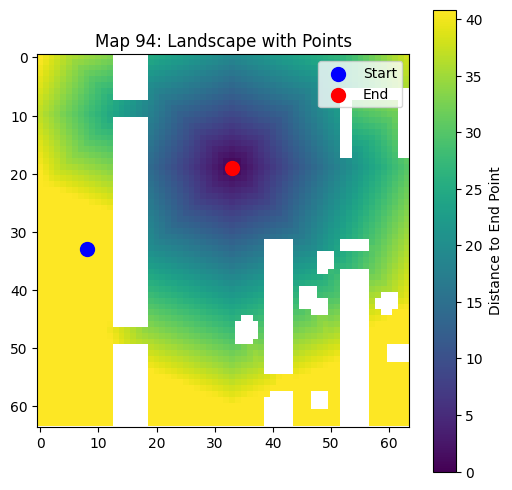

In [118]:
ind = 93

T = np.concat([cells[ind], starts[ind], goals[ind]]).reshape(3, 1, 64, 64)
pred = targets[ind]

visualizatoin.plot_map(T, ind, pred)

In [ ]:
df_alek_after = pd.read_csv('./Alek_after_fintuning_vanilla_astar_hl.csv')
df_alek_before = pd.read_csv('./Alek_before_fintuning_vanilla_astar_hl.csv')
df_alek_baseline = pd.read_csv('./alek_vanilla_astar_hl.csv')
df_tmp_unet = pd.read_csv('./vanilla_astar_hl.csv')
df_tmp_baseline = pd.read_csv('./baseline_vanilla_astar_hl.csv')

In [110]:
def CompareWithBaseline(df_baseline, df_target):
    print(f"Min devide: {(df_target.path_length / df_baseline.path_length).min():.2f}")
    
    print(f"Accuracy: {np.isclose(df_target.path_length, df_baseline.path_length).mean() * 100:.2f}")
    
    print(f"Length ratio: {(df_target.path_length / df_baseline.path_length).mean() * 100:.2f} ± " + \
          f"{(df_target.path_length / df_baseline.path_length).std() * 100:.2f}")
    
    print(f"Length RMSE: {(df_target.path_length - df_baseline.path_length).std():.2f}")
    
    print(f"Expansions ratio : {(df_target.expanded_nodes_num / df_baseline.expanded_nodes_num).mean() * 100:.2f} ± " + \
          f"{(df_target.expanded_nodes_num / df_baseline.expanded_nodes_num).std() * 100:.2f}")
    
    print(f"Expansions RMSE: {(df_target.expanded_nodes_num / df_baseline.expanded_nodes_num).median() * 100:.2f}")

In [111]:
CompareWithBaseline(df_tmp_baseline, df_tmp_unet)

Min devide: 1.00
Accuracy: 63.28
Length ratio: 101.85 ± 5.16
Length RMSE: 4.12
Expansions ratio : 2023.92 ± 2329.28
Expansions RMSE: 876.69


In [112]:
CompareWithBaseline(df_alek_baseline, df_alek_before)

Min devide: 1.00
Accuracy: 1.56
Length ratio: 148.30 ± 55.37
Length RMSE: 32.31
Expansions ratio : 306.14 ± 255.17
Expansions RMSE: 216.40


In [113]:
CompareWithBaseline(df_alek_baseline, df_alek_after)

Min devide: 1.00
Accuracy: 2.73
Length ratio: 113.53 ± 13.61
Length RMSE: 9.56
Expansions ratio : 406.12 ± 345.69
Expansions RMSE: 293.76
